In [7]:
import openturns as ot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from shapley import ShapleyIndices, ShapleyKrigingIndices
from shapley.tests import Ishigami, AdditiveGaussian
from shapley.plots import set_style_paper, plot_sensitivity_results

%load_ext autoreload
%autoreload 2

%matplotlib inline

set_style_paper()

savefigs = False
ylim = [0., 0.8]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## The model

In [8]:
model = Ishigami()
dim = model.dim
model.copula = ot.NormalCopula(dim)
theta = 0.

## Sobol indices with a classical Monte-Carlo sampling

In [9]:
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)
n_perms = None
No = 25
Ni = 50
Nv = 500

max_budget = Nv + No * Ni * np.math.factorial(dim) * (dim - 1)
n_sample = int(max_budget / (dim*4))
print('Max budget:', max_budget)

# Evaluate the model
shapley = ShapleyIndices(model.input_distribution)
shapley.build_mc_sample(model=model, n_perms=n_perms, Nv=Nv, No=No, Ni=Ni)

Max budget: 15500


In [10]:
n_boot = 1000
shapley_results = shapley.compute_indices(n_boot=n_boot)

In [11]:
shapley_results.true_first_indices = model.first_order_sobol_indices
shapley_results.true_total_indices = model.total_sobol_indices
shapley_results.true_shapley_indices = model.shapley_indices

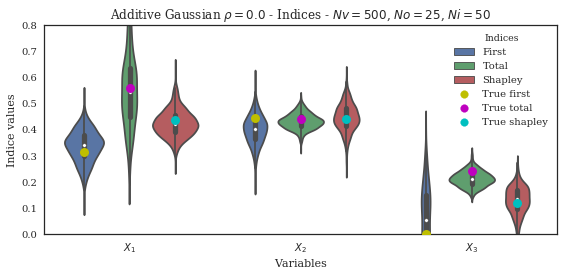

In [14]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(shapley_results, indice='all', ax=ax)
ax.set_title("Additive Gaussian $\\rho = {0}$ - Indices - $Nv={1}$, $No={2}$, $Ni={3}$".format(theta, Nv, No, Ni))
ax.set_ylim(ylim)
fig.tight_layout()
if savefigs:
    fig.savefig('./output/shapley_additive_gaussian.pdf')

In [15]:
def get_confidence_interval(results, quantiles=[2.5, 97.5]):
    """
    """
    interval = 2*results[:, 0].T - np.percentile(results, quantiles[::-1], axis=1)
    return interval.T

In [16]:
get_confidence_interval(shapley_results.full_shapley_indices)

array([[ 0.31567024,  0.52136609],
       [ 0.35077617,  0.55486759],
       [ 0.02955357,  0.23290069]])

In [17]:
get_confidence_interval(shapley_results.full_first_indices)

array([[ 0.20504754,  0.43850801],
       [ 0.27233133,  0.49261349],
       [-0.25391445,  0.30213961]])

In [18]:
get_confidence_interval(shapley_results.full_total_indices)

array([[ 0.23739929,  0.83243252],
       [ 0.38567111,  0.50455064],
       [ 0.16480211,  0.27287504]])

## Kriging Model

In [40]:
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)
model_budget = 200
basis = 'quadratic'
kernel = 'matern'
library = 'sklearn'
sampling = 'lhs'
shapley_kriging = ShapleyKrigingIndices(model.input_distribution)
meta_model = shapley_kriging.build_meta_model(model, n_sample=model_budget, basis_type=basis, kernel=kernel, library=library,
                                             sampling=sampling)

In [41]:
%%time
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)
n_realization = 50
No = 50
Ni = 100
Nv = 1000
max_budget = Nv + No * Ni * np.math.factorial(dim) * (dim - 1)
n_sample = int(max_budget / (dim*4))
print('Max budget:', max_budget)

# Evaluate the kriging model
shapley_kriging.build_mc_sample(model=meta_model, n_perms=None, Nv=Nv, No=No, Ni=Ni, n_realization=n_realization)

Max budget: 61000
Sample size is too large. A loop is done to save memory.
Wall time: 29.7 s


In [37]:
n_boot = 1000
shapley_kriging_results = shapley_kriging.compute_indices(n_boot=n_boot)

In [38]:
shapley_kriging_results.true_first_indices = model.first_order_sobol_indices
shapley_kriging_results.true_total_indices = model.total_sobol_indices
shapley_kriging_results.true_shapley_indices = model.shapley_indices

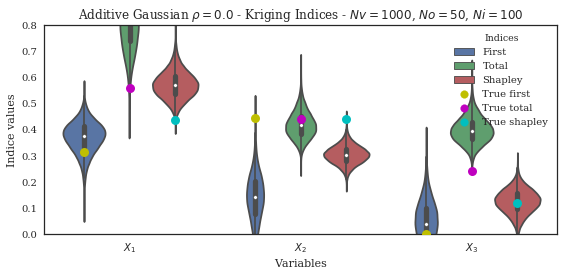

In [39]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(shapley_kriging_results, indice='all', ax=ax)
ax.set_title("Additive Gaussian $\\rho = {0}$ - Kriging Indices - $Nv={1}$, $No={2}$, $Ni={3}$".format(theta, Nv, No, Ni))
ax.set_ylim(ylim)
fig.tight_layout()
if savefigs:
    fig.savefig('./output/shapleyGP_additive_gaussian.pdf')